In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
import nltk

In [4]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>


False

In [2]:
# Data loading and preprocessing
train_dir = './train/'
X_train1 = []
y_train1 = []

for folder in os.listdir(train_dir):
    img = cv2.imread(os.path.join(train_dir, folder, 'images', folder+'.jpeg'))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    X_train1.append(img)
    
    mask_name = os.listdir(os.path.join(train_dir, folder, 'masks'))[0]
    mask = cv2.imread(os.path.join(train_dir, folder, 'masks', mask_name))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (256, 256))
    y_train1.append(mask)

X_train = np.array(X_train1).reshape(-1, 256, 256, 1)
y_train = np.array(y_train1).reshape(-1, 256, 256, 1)

In [3]:
def segnet(input_shape=(256, 256, 1), num_classes=1):
    model = models.Sequential()

    # Encoder
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=input_shape))

    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same'))

    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(512, (3, 3), padding='same'))

    model.add(layers.Activation('relu'))

    # Decoder
    model.add(layers.Conv2D(512, (3, 3), padding='same'))

    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D(size=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same'))

    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D(size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same'))

    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D(size=(2, 2)))

    model.add(layers.Conv2D(num_classes, (3, 3), padding='same'))
    model.add(layers.Activation('sigmoid'))

    return model


In [4]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, dtype='float32')  # Cast y_true to float32
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

In [5]:
X_train1 = X_train[0:500, :]
y_train1 = y_train[0:500, :]
y_train1 = (y_train1 > 0).astype(np.uint8)


In [6]:
# Model compilation
model = segnet()
model.compile(optimizer=Adam(lr=0.000001), loss='binary_crossentropy' ,metrics=[dice_coef])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 activation (Activation)     (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 activation_1 (Activation)   (None, 128, 128, 128)     0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                   

In [113]:
model.fit(X_train1, y_train1, epochs=5, batch_size=8, validation_split=0.2)

Epoch 1/5
50/50 [==============================] - 178s 4s/step - loss: 0.0027 - dice_coef: 0.7909 - val_loss: 0.0309 - val_dice_coef: 0.5246
Epoch 2/5
50/50 [==============================] - 197s 4s/step - loss: 0.0025 - dice_coef: 0.7923 - val_loss: 0.0373 - val_dice_coef: 0.5433
Epoch 3/5
50/50 [==============================] - 201s 4s/step - loss: 0.0022 - dice_coef: 0.8175 - val_loss: 0.0383 - val_dice_coef: 0.5681
Epoch 4/5
50/50 [==============================] - 204s 4s/step - loss: 0.0028 - dice_coef: 0.7541 - val_loss: 0.0392 - val_dice_coef: 0.5839
Epoch 5/5
50/50 [==============================] - 252s 5s/step - loss: 0.0022 - dice_coef: 0.8146 - val_loss: 0.0453 - val_dice_coef: 0.6119


In [10]:
# Data loading for testing
test_dir = './test/'
X_test = []

for folder in os.listdir(test_dir):
    img = cv2.imread(os.path.join(test_dir, folder, 'images', folder+'.jpeg'), cv2.IMREAD_GRAYSCALE)
    # img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (256, 256))
    X_test.append(img)

X_test = np.array(X_test).reshape(-1, 256, 256, 1)

In [36]:
# Model prediction on test data
predictions = model.predict(X_test)

12/12 [==============================] - 58s 5s/step


In [109]:

predictions1=(predictions > 0).astype(np.int8)
np.mean(predictions)
predictions[24][75][103]

array([5.821813e-23], dtype=float32)

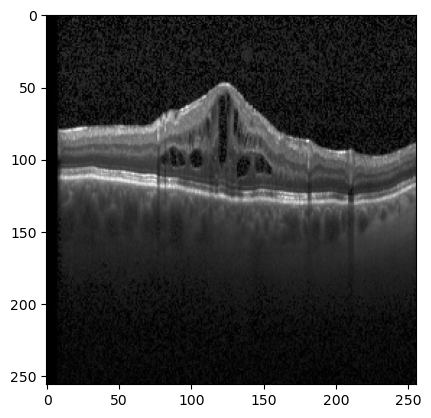

In [110]:

plt.imshow(X_test[200], cmap='gray')
plt.show()

In [111]:
# predictions

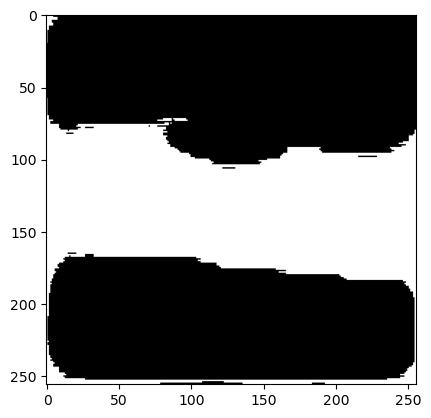

In [112]:

plt.imshow(predictions1[200], cmap='gray')
plt.show()

In [104]:
model.save('dme_model.h5')

D:\anconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
